# Data Analysis Workshop

## Tutorial I: Search and query, accessing and Cataloging the dataset

In this tutorial, we’ll learn how to use the `freva-client` library to explore and access available datasets and at the end customize the dataset on Freva based on own desire.
To get started, we’ll run a simple analysis on the [MPI Grand Ensemble data](https://mpimet.mpg.de/en/research/modeling/grand-ensemble), a large collection of climate simulations.
The data browser organizes metadata in a **tree-like hierarchy**. At the top of this structure is the **`project`** level.

First let's setup and learn about authentication and then keep up with the rest.

## Installation

#### The Client Library

| Environment | Installation Command |
|-------------|---------------------|
| DKRZ/Levante (Recommended) | `$ module load clint gems`(Terminal) <br> `In [1]: !module load clint gems`(Jupyterhub) |
| Conda (Local) | $ `conda create -n freva-client-env -c conda-forge freva-client -y` |
| Python (Local) | `$ pip install freva-client` |


**ATTENTION**: For the Freva Databrowser workshop, please open the new Jupyter as Terminal and write the following:
```bash
$ module load clint gems
$ da-workshop-setup
```
And then from kernel environment list, please choose, `DA Workshop (python)`
Now your environment is ready to start!


Let quickly ckeck if `freva-client` is available on our current kernel environemnt or not!

In [2]:
from freva_client import databrowser, __version__
print(__version__)

2508.0.0


## Querying Data

First and foremost, let's findout which search keys are avaiable on the system:

In [ ]:
databrowser.metadata_search().keys()

Let's assume we know that the Grand-Ensemble data is stored under `mpi-ge` but we don't know whether it's under `project` or `product` etc. The databrowser is here to help. You can simply use the `facet` argument to search for all entries containing a certain value, such as `mpi-ge`. Let's get the project(s) of all search keys (or facets) that contain `mpi-ge`

In [ ]:
databrowser.metadata_search("mpi-ge")["project"]

In this toturial, we are going to create a time series of 2 m air temperature.

To do so we have to check if the `tas` variable is available. We can use the `metadata_search` function:

In [ ]:
"tas" in databrowser.metadata_search("mpi-ge")["variable"]

Let's query the available ouput time frequencies:

In [ ]:
databrowser.metadata_search("mpi-ge", variable="tas")["time_frequency"]

Now we do have a rough overview of the available data, to access the data create a so called `instance` of the databrowser class. We want to cover future scenarios, that is timesteps from today until 2100.  

In [ ]:
db = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12")
db

To check how many files were found we can apply the `len` function to our instance:

In [ ]:
len(db)

Just like with the `metadata_search` method we can check the meta data with using `metadata` property. This will give you the metdata search parameters that were used to create the `db` object:

In [ ]:
db.metadata["experiment"]

The `picontrol` experiment is unexpceted. Let's check the what is going on. We create a new search and check the files belonging to that search:

In [ ]:
pcontrol = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment="picontrol")
len(pcontrol)

To get the files we can "convert" our search to a list

In [ ]:
files = list(pcontrol)
files

Let's do a reverse search, that is check what meta data is assocaited with a file: 

In [ ]:
databrowser.metadata_search(file=files[0])

Since we don't want this pre-industrial control run in our databrowser search we tell the databrowser to not use it. We can use the `!` to *not* include a certain value

In [ ]:
db = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment="!picontrol")
db.metadata["experiment"]

Now let's try to create a global time series for each of the experiments. Since we are going to use `xarray` and xarray doesn't support area weights out of box we have to create a helper function:

In [15]:
import xarray as xr
import numpy as np
def field_mean(
    data: xr.DataArray,
    lat_name: str = "lat",
    lon_name: str = "lon",
    mean_dims: tuple[str, str] = ("lat", "lon")
) -> xr.DataArray:
    """
    Compute an area-weighted mean over latitude and longitude using cosine latitude weights.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with latitude and longitude coordinates.
    lat_name : str, optional
        Name of the latitude coordinate. Default is "lat".
    lon_name : str, optional
        Name of the longitude coordinate. Default is "lon".
    mean_dims : Sequence[str], optional
        Dimensions over which to compute the mean. Default is ("lat", "lon").

    Returns
    -------
    xr.DataArray
        Area-weighted mean of the input data over the specified dimensions.
    """
    # Extract latitude values
    lat = data[lat_name]

    # Compute cosine of latitude in radians
    weights = np.cos(np.deg2rad(lat))

    # Normalize weights so they sum to 1 (over just lat)
    weights /= weights.sum()

    # Apply weighted mean over specified dimensions
    return data.weighted(weights).mean(dim=mean_dims, keep_attrs=True)

We can use the search result of the databrowser object to directly open dataset in xarray:

In [ ]:
time_series = {}
for exp in db.metadata["experiment"]:
    ensembles = []
    # Go throuhg all ensembles, this might take some time (let's make a cut at 5 member for demo purposes)
    member = sorted(databrowser.metadata_search(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment=exp)["ensemble"])
    for num, member in enumerate(member):
        print(f"Reading data and calculating TS for experiment {exp} in ens: {member}", end="\r")
        ds = xr.open_mfdataset(databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment=exp, ensemble=member))
        # Add an ensemble and experiment dimension as we combine the data set later
        ts = field_mean(ds["tas"]).expand_dims(ensemble=[member], experiment=[exp])
        ensembles.append(ts)
        if num == 4:
            break
    time_series[exp] = xr.concat(ensembles, dim="ensemble", combine_attrs="override")
# Combine the experiments into one dataset
data = xr.concat(time_series.values(), dim="experiment", combine_attrs="override")
data

Let's plot the data:

In [ ]:
import matplotlib.pyplot as plt

# Create a color cycle for different experiments
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(figsize=(12, 5))

for i, exp in enumerate(data.experiment.values):
    ts = data.sel(experiment=exp).resample(time="1YE").mean()
    ts_min = ts.min(dim="ensemble").squeeze()
    ts_max = ts.max(dim="ensemble").squeeze()
    ts_mean = ts.mean(dim="ensemble").squeeze()
    # Plot min–max shading
    plt.fill_between(
        ts.time,
        ts_min,
        ts_max,
        color=colors[i % len(colors)],
        alpha=0.2,
        label=None,
    )
    # Plot mean line
    plt.plot(
        ts.time,
        ts_mean,
        color=colors[i % len(colors)],
        linewidth=2,
        label=f"{exp}"
    )

# Add plot decorations
plt.title("Ensemble Mean and Spread for Each Experiment")
plt.xlabel("Time")
plt.ylabel(f"{data.attrs['long_name']} [{data.attrs['units']}]")  # Replace with actual units
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Cataloging Datasets:

Now that you’ve already found your target dataset on Freva, you may want to export the full metadata for project's partner who don’t have direct Freva access or you want to download it and access somewhere else on any other HPC system.

In this section we are going to introduce two different types of Cataloues: 
1. The **intake-esm** catalog provides a lightweight, Python-friendly interface to the metadata of large Earth System Model archives. By pointing to a central JSON index, it lets you discover, filter, and load climate model outputs—such as temperature, precipitation, or ocean variables—without downloading entire datasets. The catalog structure follows the CMIP/ESM conventions, enabling easy subsetting by attributes like project name, variable, experiment, and time period. Once exported as a standalone YAML file, your subsetted catalog can be shared with collaborators who can query and load data locally, with no direct access to the original archive required.


2. The **STAC (SpatioTemporal Asset Catalog)** static catalog defines a simple, filesystem-based layout for geospatial metadata. A static catalog bundles Catalog, Collection, and Item JSON files into a set of directories that mirror your data hierarchy, with no dynamic search API. Bundling the entire catalog into a ZIP archive makes it trivial to distribute or archive a snapshot of your dataset inventory—satellite imagery, climate projections, or any spatiotemporal assets—for offline use, disaster recovery, or reproducible analyses. Once unzipped, the folder structure and JSON files provide the same discovery semantics as a live STAC endpoint.  


First, we’ll use [intake-esm](https://intake-esm.readthedocs.io/en/stable/) to:

Subset by our chosen search keys:  
- project: `mpi-ge`
- time_frequency: `mon`
- variable: `tas`
- time: `'2025-01 to 2100-12'`
- experiment: `picontrol`


In [3]:
db = databrowser(project="mpi-ge", variable="tas", time_frequency="mon", time="2025-01 to 2100-12", experiment="picontrol")

In [ ]:
db.intake_catalogue()

We’ll now perform the same operation on a STAC static catalog: download the entire catalog as a ZIP archive so you can share or inspect it offline.


In [ ]:
db.stac_catalogue()

To complete our explanation about STAC catalog, the **STAC static catalog** is implemented as a set of flat files on a web server or object store (e.g., S3). It exposes the same Item, Catalog, and Collection JSON structure as a dynamic STAC, but without a `/search` endpoint—making it easy to bundle and distribute as a ZIP for disaster recovery or offline use

## Add/Remove dataset to/from Freva framework

So far in this tutorial, we’ve learned how to search for datasets, inspect metadata, and access data directly from Freva’s indexed resources. But what if you want to work with data that isn’t yet indexed, like your own model simulations or derived statistics?

In this next section, we’ll walk through how to register your own dataset with Freva’s databrowser:

1. Prepare your data
   We’ll use a sample file of extreme‐value statistics (dummy sea surface temperature extremes), but you can point to any local or remote dataset you’ve generated.

2. Open the dataset  
   Loading the file locally allows Freva to auto-extract core metadata attributes (e.g., dimensions, coordinate variables).

3. Define missing metadata
   For any required fields not present in the file (project, experiment, realm, etc.), we’ll set the appropriate Freva attributes.

4. Ingest into Freva
   You’ll see how to add the dataset to the databrowser index—and afterward, how to remove it again, to demonstrate both ingestion and deletion workflows.

By the end of this section, you’ll be able to make your own simulations and analyses discoverable alongside Freva’s curated archives.

In [30]:
import numpy as np, xarray as xr, os
from getpass import getuser
time = np.arange("2025-01","2026-01",dtype="datetime64[M]")
lat, lon = np.linspace(-30,30,121), np.linspace(120,290,171)
da = (xr.DataArray(28 - 0.006*(lon-230), dims=("lon",), coords={"lon":lon})
      .expand_dims(time=time, lat=lat))
da.name = "sst"; da.attrs.update(long_name="Idealized Pacific SST", units="°C")
da.to_netcdf(f"dummy_sst_{getuser()}.nc")
print(f"check if dummy_sst_{getuser()}.nc exists: {os.path.exists(f'dummy_sst_{getuser()}.nc')}")

check if dummy_sst_k202187.nc exists: True


/home/k/k202187/dev/20250803/venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/k/k202187/dev/20250803/venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/k/k202187/dev/20250803/venv/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


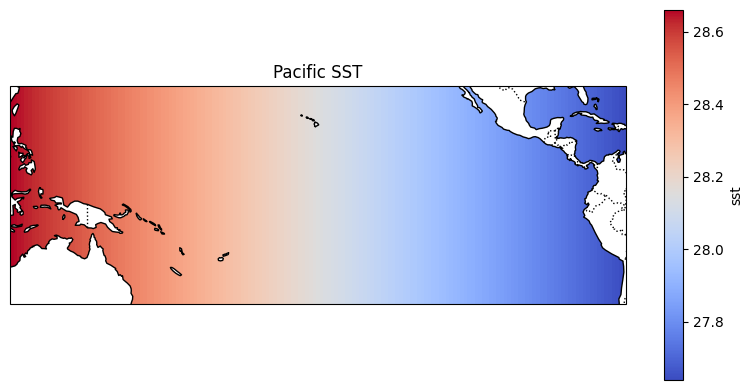

In [32]:
import matplotlib.pyplot as plt, cartopy.crs as ccrs, cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(projection=ccrs.PlateCarree(180)))
da.mean("time").plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", add_colorbar=True)

ax.add_feature(cfeature.LAND, facecolor="white", zorder=2); ax.coastlines(zorder=3); ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=3)
plt.title("Pacific SST"); plt.tight_layout(); plt.show()

Now we are going to add this dummy SST data to the Freva

In [33]:
global_attributes = {"project": "userdata", "product": "stats", "model": "IFS", "experiment": "ETCCDI", "realm": "atmos"}
databrowser.userdata(
    action="add",
    userdata_items=[f"{os.getcwd()}/dummy_sst_{getuser()}.nc"],
    metadata=global_attributes,
    host="https://www.gems.dkrz.de",
)

1 have been successfully added to the databrowser. 0 files were duplicates and not added.

This response shows that the data has been successfully added to Freva. Now we can query the data to see if the data is on Freva

In [35]:
databrowser.metadata_search(flavour="user", user=getuser())

{'ensemble': [],
 'experiment': ['etccdi'],
 'institute': [],
 'model': ['ifs'],
 'product': ['stats'],
 'project': ['userdata'],
 'realm': ['atmos'],
 'time_aggregation': ['mean'],
 'time_frequency': ['mon'],
 'variable': ['sst']}

Since we are sure that the data has been added to the Freva, we can remove it via the following command:

In [36]:
global_attributes = {"project": "userdata", "product": "stats", "model": "IFS", "experiment": "ETCCDI", "realm": "atmos"}
databrowser.userdata(
    action="delete",
    metadata=global_attributes,
    host="https://www.gems.dkrz.de",
)

User data deleted successfully